# **Google Drive**

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

Mon Feb 24 15:46:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Install**

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# !pip install soundfile #windows
!pip install sox #linux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40037 sha256=ee506e20c713487619d7e315ca86ac2442cb6f974990755cc71bbfb840e7143d
  Stored in directory: /root/.cache/pip/wheels/74/89/93/023fcdacaec4e5471e78b43992515e8500cc2505b307e2e6b7
Successfully built sox


In [ ]:
!pip install librosa

# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import librosa
from tqdm import tqdm

from IPython.display import Audio

In [ ]:
str(torchaudio.get_audio_backend())

<ipython-input-7-4bc9ba66fd25>:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  str(torchaudio.get_audio_backend())


'None'

In [ ]:
print(torch.__version__)
print(torchaudio.__version__)

2.5.1+cu124
2.5.1+cu124


# **Utils 🧰**

In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# **Load Audio** 🎵

In [ ]:
cp -r /content/drive/MyDrive/audio_clips/ .

In [52]:
Audio('/content/audio_clips/orange/orange_01.wav')

### info

In [53]:
metadata = torchaudio.info('/content/audio_clips/orange/orange_01.wav')
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=48000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


### load

Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.463
 - Min:     -0.364
 - Mean:     0.000
 - Std Dev:  0.030

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



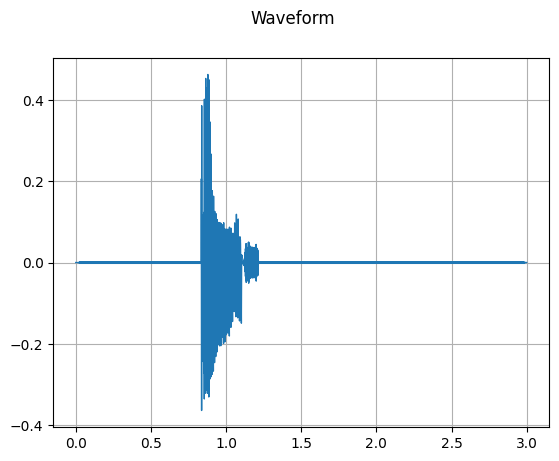

In [54]:
waveform, sample_rate = torchaudio.load('/content/audio_clips/orange/orange_01.wav')
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.463
 - Min:     -0.364
 - Mean:     0.000
 - Std Dev:  0.030

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



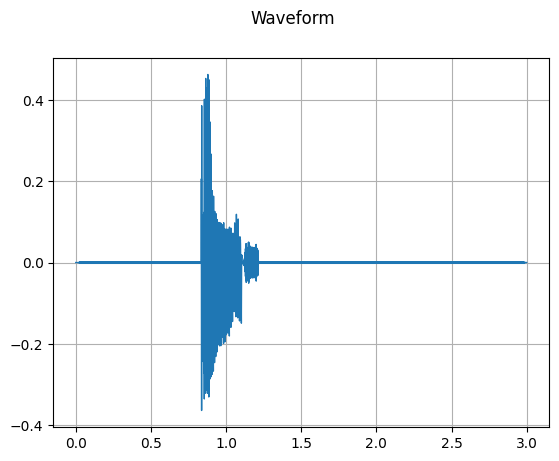

In [55]:
waveform2 = waveform.mean(dim=0, keepdim=True)
print_stats(waveform2, sample_rate)
plot_waveform(waveform2, sample_rate)
Audio(waveform2.numpy(), rate=sample_rate)

Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.463
 - Min:     -0.364
 - Mean:     0.000
 - Std Dev:  0.030

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



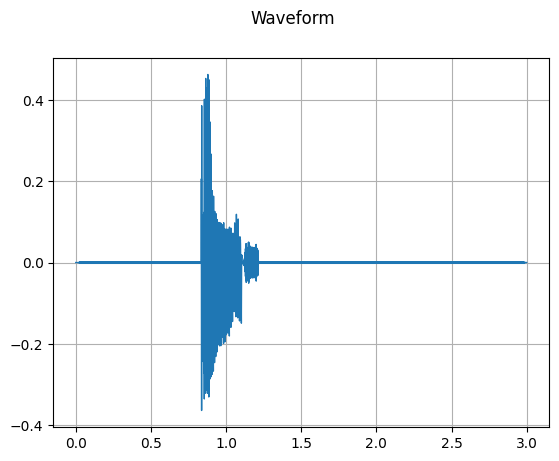

In [56]:
waveform, sample_rate = torchaudio.load('/content/audio_clips/orange/orange_01.wav')
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 16000
Shape: (1, 20000)
Dtype: torch.float32
 - Max:      0.463
 - Min:     -0.364
 - Mean:     0.000
 - Std Dev:  0.046

tensor([[ 0.0004,  0.0000, -0.0002,  ..., -0.0012, -0.0013, -0.0002]])



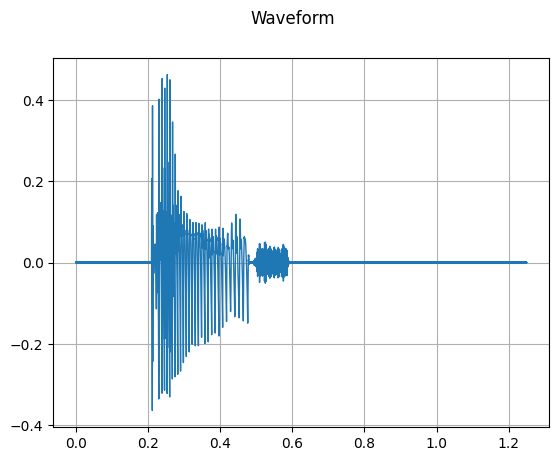

In [57]:
waveform, sample_rate = torchaudio.load('/content/audio_clips/orange/orange_01.wav',
                                        num_frames=20000,
                                        frame_offset=10000)
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 16000
Shape: (1, 20000)
Dtype: torch.float32
 - Max:      0.463
 - Min:     -0.364
 - Mean:     0.000
 - Std Dev:  0.046

tensor([[ 0.0004,  0.0000, -0.0002,  ..., -0.0012, -0.0013, -0.0002]])



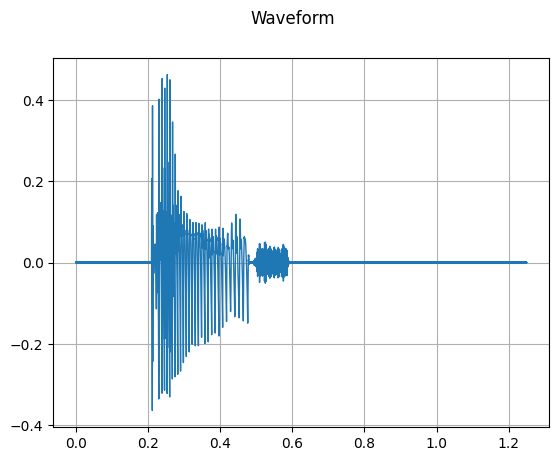

In [58]:
waveform, sample_rate = torchaudio.load('/content/audio_clips/orange/orange_01.wav')
waveform = waveform[:, 10000:30000]
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

### save

In [59]:
torchaudio.save('/content/audio_clips/orange/orange_01.wav',
                waveform,
                sample_rate)

# **Dataset 🗂️**

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

data_dir = "audio_clips"
csv_file = "audio_clips/dataset.csv"
output_dir = "split"

df = pd.read_csv(csv_file)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

for dataset, dataset_df in zip(["train", "test"], [train_df, test_df]):
  for _, row in dataset_df.iterrows():
    filename = row['filename']
    label = row['label']

    source_path = os.path.join(data_dir, label, filename)

    destination_folder = os.path.join(output_dir, dataset, label)
    os.makedirs(destination_folder, exist_ok=True)
    destination_path = os.path.join(destination_folder, filename)
    shutil.copy(source_path, destination_path)

train_df.to_csv("split/train_labels.csv", index=False)
test_df.to_csv("split/test_labels.csv", index=False)

In [41]:
import torch
import torchaudio
from torch.utils.data import Dataset

class CustomSpeechDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        audio_path = os.path.join(self.data_dir, label, filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, sample_rate, label

train_dataset = CustomSpeechDataset(csv_file="split/train_labels.csv", data_dir="split/train/")
test_dataset = CustomSpeechDataset(csv_file="split/test_labels.csv", data_dir="split/test/")

print(f"Train Samples: {len(train_dataset)}, Test Samples: {len(test_dataset)}")

Train Samples: 192, Test Samples: 48


In [43]:
len(train_dataset), len(test_dataset)

(192, 48)

In [72]:
labels = set([d[2] for d in test_dataset])
label2num = {label:num for num, label in enumerate(labels)}
print(label2num)

{'unknown': 0, 'apple': 1, 'orange': 2, 'cherry': 3}


In [73]:
def collate_fn(batch):
  data = [b[0][0] for b in batch]
  data = pad_sequence(data, batch_first=True)
  labels = torch.LongTensor([label2num[b[2]] for b in batch])
  return data, labels

In [74]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [75]:
x, y = next(iter(train_loader))
x.shape, y

(torch.Size([32, 48000]),
 tensor([3, 1, 2, 2, 0, 1, 3, 3, 0, 2, 3, 3, 3, 1, 1, 3, 3, 0, 0, 2, 2, 0, 2, 1,
         0, 0, 2, 3, 3, 1, 1, 3]))

# **Model 🧠**

## Define Model

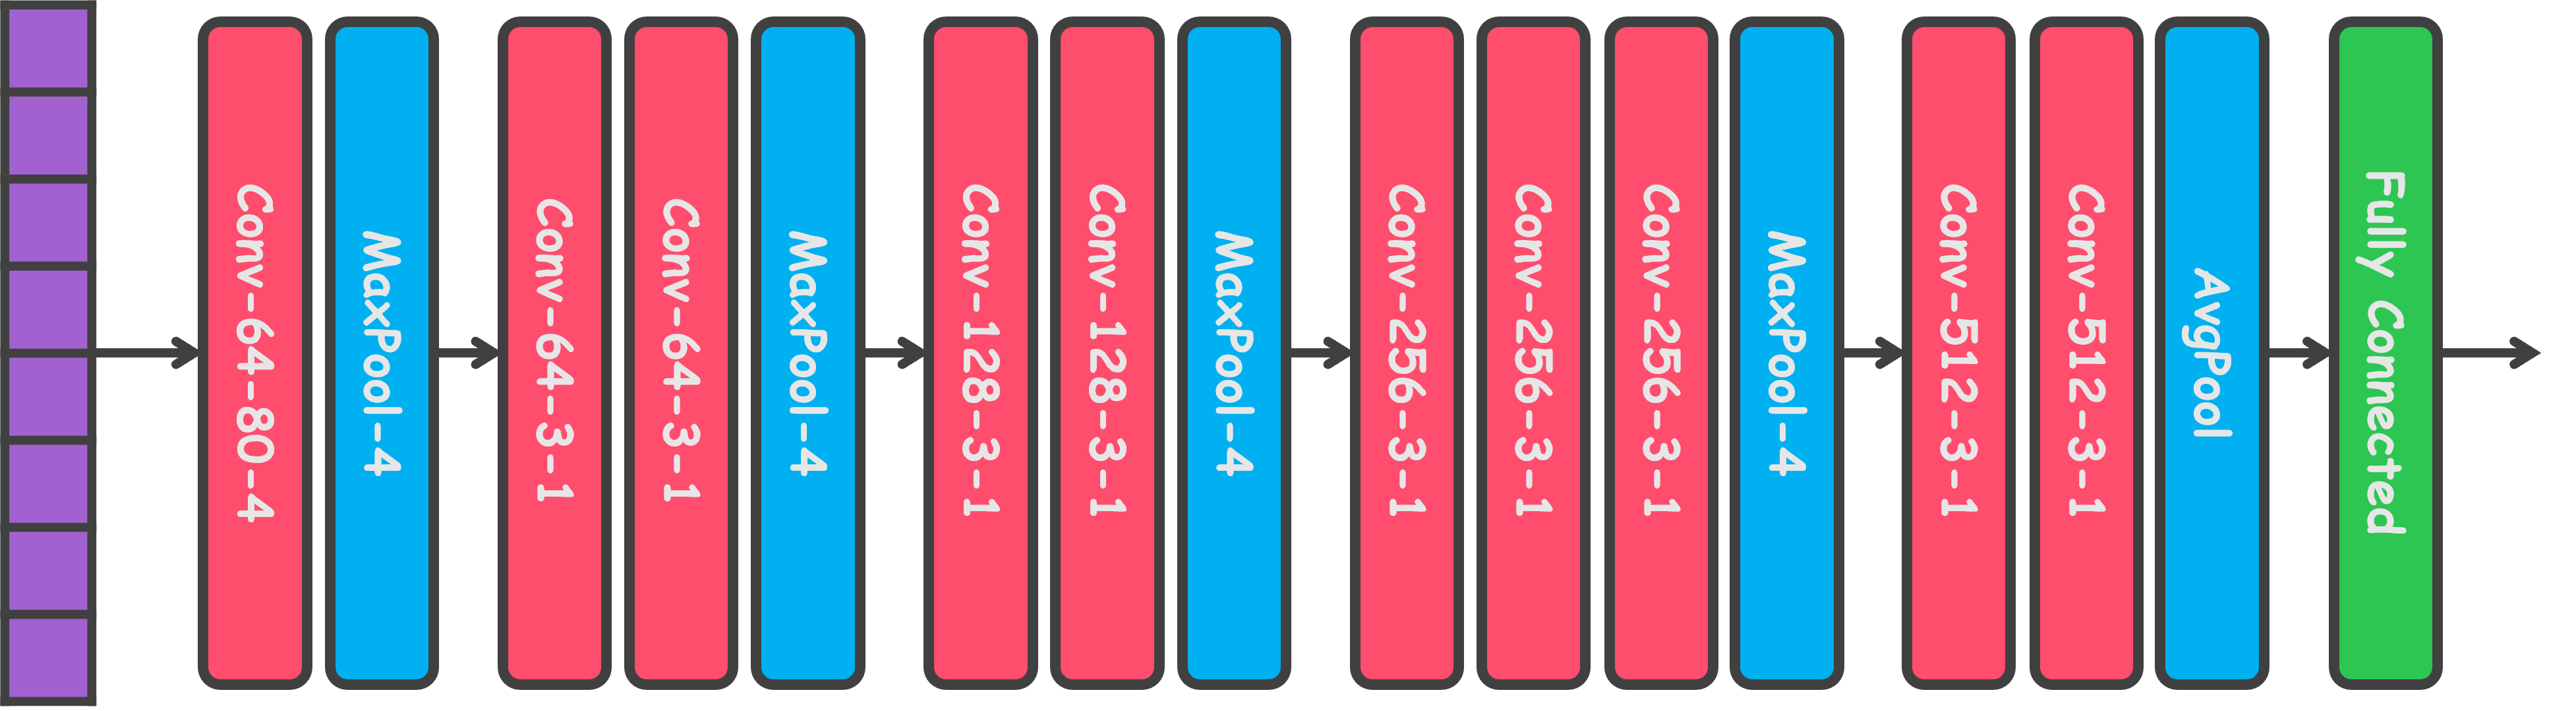

In [76]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [78]:
model = M5(n_input=1, n_output=35)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [79]:
num_params(model)

0.026915

## Pretrained Model

In [80]:
bundle = pipelines.WAV2VEC2_BASE
bundle

Wav2Vec2Bundle(_path='wav2vec2_fairseq_base_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': None}, _sample_rate=16000, _normalize_waveform=False, _model_type='Wav2Vec2')

In [81]:
model = bundle.get_model()
model.to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:03<00:00, 115MB/s]


Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [82]:
model.feature_extractor
model.encoder
model.training

False

In [83]:
out = model(torch.randn((2, 16000), device=device))
out[0].shape

torch.Size([2, 49, 768])

In [84]:
class Wav2Vec2Cls(nn.Module):

  def __init__(self, num_cls):
    super().__init__()
    bundle = pipelines.WAV2VEC2_BASE
    self.feature_extractor = bundle.get_model()
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    y = self.feature_extractor(x)
    preds = self.fc(y[0])
    return preds

In [85]:
model = Wav2Vec2Cls(35)
model.to(device)

Wav2Vec2Cls(
  (feature_extractor): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 7

In [86]:
model(torch.randn((2, 16000), device=device))

tensor([[[-1.8141e-01, -1.9480e-01,  6.2536e-02,  ..., -7.6592e-02,
          -1.6292e-01, -8.4444e-02],
         [-1.7960e-01, -2.1363e-01,  4.4059e-02,  ..., -6.7553e-02,
          -1.7809e-01, -5.7249e-02],
         [-2.2910e-01, -2.7150e-01,  5.8571e-02,  ..., -6.3350e-02,
          -1.2189e-01, -2.4811e-02],
         ...,
         [-1.7510e-01, -2.3803e-01,  3.2034e-02,  ..., -2.1628e-02,
          -1.6203e-01, -6.0724e-02],
         [-1.7820e-01, -2.4976e-01,  3.8398e-02,  ..., -4.4869e-02,
          -1.4566e-01, -3.5525e-02],
         [-1.8438e-01, -2.5547e-01,  4.9384e-02,  ..., -4.4179e-02,
          -1.4165e-01, -5.0608e-03]],

        [[-2.0676e-01, -2.8416e-01,  6.9209e-02,  ...,  1.3732e-01,
          -1.6294e-01,  1.8316e-03],
         [-2.4869e-01, -3.5317e-01,  5.9405e-02,  ...,  8.4788e-02,
          -1.6392e-01,  6.4049e-02],
         [-2.6941e-01, -3.3662e-01,  4.0454e-02,  ...,  8.6961e-02,
          -1.9888e-01,  1.7204e-02],
         ...,
         [-2.2467e-01, -3

In [88]:
num_params(model)

94.397859

In [89]:
model.feature_extractor.training
# model.feature_extractor.requires_grad_(True)
model.fc.training

True

# **Speech Command Classification 🎹**

## Utils

In [117]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [118]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

## Init

In [119]:
num_cls = 35

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [120]:
labels = set([d[2] for d in test_dataset])
label2num = {label:num for num, label in enumerate(labels)}
print(label2num)

{'unknown': 0, 'apple': 1, 'orange': 2, 'cherry': 3}


In [121]:
def collate_fn(batch):
  data = [b[0][0] for b in batch]
  data = pad_sequence(data, batch_first=True)
  data = AF.resample(data, 16000, 8000).unsqueeze(1)
  labels = torch.LongTensor([label2num[b[2]] for b in batch])
  return data, labels

In [122]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [123]:
x, y = next(iter(train_loader))
x.shape, y

(torch.Size([32, 1, 24000]),
 tensor([0, 1, 1, 0, 2, 0, 0, 1, 2, 3, 3, 3, 3, 3, 0, 0, 2, 1, 1, 1, 0, 2, 3, 0,
         0, 1, 3, 3, 3, 2, 3, 2]))

## Model

In [124]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x.squeeze(1)

In [125]:
model = M5(n_input=1, n_output=num_cls)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

## Functions

In [140]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch):
    model.train()
    loss_train = AverageMeter()

    acc_train = Accuracy(task="multiclass", num_classes=4).to(device)

    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            preds = outputs.argmax(dim=1)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            loss_train.update(loss.item(), inputs.size(0))
            acc_train.update(preds, targets)

            tepoch.set_postfix(loss=loss_train.avg, acc=acc_train.compute().item())

    return model, loss_train.avg, acc_train.compute().item()


In [169]:
def validation(model, test_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_test = Accuracy(task="multiclass", num_classes=4).to(device)

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)


            preds = outputs.argmax(dim=1)
            acc_test.update(preds, targets.int())

            loss_valid.update(loss.item())

    return loss_valid.avg, acc_test.compute().item()


## Train

### Step 1: check forward path

Calculate loss for one batch

In [242]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(3.3844, device='cuda:0', grad_fn=<NllLossBackward0>)


### Step 2: check backward path

Select 5 random batches and train the model

In [243]:
_, mini_train_dataset = random_split(train_dataset,
                                     (len(train_dataset)-7, 7))
mini_train_loader = DataLoader(mini_train_dataset, 20, collate_fn=collate_fn)

In [244]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

In [245]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [246]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

torch.save(model.state_dict(), 'model.pt')

100%|██████████| 1/1 [00:00<00:00, 11.88batch/s, acc=1, loss=0.0218]


### Step 3: select best lr

Train all data for one epoch

In [247]:
num_epochs = 1
for lr in [0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = M5(n_input=1, n_output=num_cls).to(device)
  model.load_state_dict(torch.load('model.pt'))
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-3, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

<ipython-input-247-ff92702d1c99>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))


LR=0.01


100%|██████████| 6/6 [00:02<00:00,  2.63batch/s, acc=0.406, loss=1.89]



LR=0.001


100%|██████████| 6/6 [00:02<00:00,  2.34batch/s, acc=0.354, loss=2.28]



LR=0.0001


100%|██████████| 6/6 [00:03<00:00,  1.83batch/s, acc=0.354, loss=2.35]

### Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



Augmentation

### Step 5: train more epochs

In [248]:
model = M5(n_input=1, n_output=num_cls).to(device)
model.load_state_dict(torch.load('model.pt'))

<ipython-input-248-3449b28c163f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

In [249]:
lr = 0.01
wd = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [250]:
loss_train_hist = []
loss_test_hist = []

acc_train_hist = []
acc_test_hist = []

best_loss_test = torch.inf
epoch_counter = 0

In [251]:
num_epochs = 50

for epoch in range(num_epochs):
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  loss_valid, acc_test = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_test_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_test_hist.append(acc_test)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_test:.4}')
  print()

  epoch_counter += 1

100%|██████████| 6/6 [00:02<00:00,  2.17batch/s, acc=0.391, loss=1.87]


Valid: Loss = 5.47, Acc = 0.25



100%|██████████| 6/6 [00:02<00:00,  2.14batch/s, acc=0.604, loss=0.952]


Valid: Loss = 4.667, Acc = 0.25



100%|██████████| 6/6 [00:02<00:00,  2.58batch/s, acc=0.719, loss=0.697]


Valid: Loss = 3.944, Acc = 0.25



100%|██████████| 6/6 [00:02<00:00,  2.55batch/s, acc=0.755, loss=0.6]


Valid: Loss = 3.325, Acc = 0.25



100%|██████████| 6/6 [00:02<00:00,  2.63batch/s, acc=0.885, loss=0.476]


Valid: Loss = 2.701, Acc = 0.25



100%|██████████| 6/6 [00:03<00:00,  1.82batch/s, acc=0.875, loss=0.401]


Valid: Loss = 1.945, Acc = 0.2917



100%|██████████| 6/6 [00:02<00:00,  2.59batch/s, acc=0.917, loss=0.311]


Valid: Loss = 1.299, Acc = 0.5208



100%|██████████| 6/6 [00:02<00:00,  2.60batch/s, acc=0.953, loss=0.243]


Valid: Loss = 1.102, Acc = 0.5833



100%|██████████| 6/6 [00:02<00:00,  2.63batch/s, acc=0.984, loss=0.169]


Valid: Loss = 0.7649, Acc = 0.7708



100%|██████████| 6/6 [00:03<00:00,  1.74batch/s, acc=0.99, loss=0.141]


Valid: Loss = 0.7284, Acc = 0.7292



100%|██████████| 6/6 [00:02<00:00,  2.62batch/s, acc=0.984, loss=0.114]


Valid: Loss = 0.4765, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.61batch/s, acc=0.99, loss=0.106]


Valid: Loss = 0.4731, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.56batch/s, acc=1, loss=0.0748]


Valid: Loss = 0.4351, Acc = 0.9375



100%|██████████| 6/6 [00:03<00:00,  1.95batch/s, acc=1, loss=0.0528]


Valid: Loss = 0.4319, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.37batch/s, acc=1, loss=0.0624]


Valid: Loss = 0.7933, Acc = 0.6667



100%|██████████| 6/6 [00:02<00:00,  2.63batch/s, acc=1, loss=0.0533]


Valid: Loss = 0.3997, Acc = 0.8958



100%|██████████| 6/6 [00:02<00:00,  2.57batch/s, acc=0.995, loss=0.0628]


Valid: Loss = 0.4061, Acc = 0.8958



100%|██████████| 6/6 [00:02<00:00,  2.29batch/s, acc=1, loss=0.0406]


Valid: Loss = 0.6678, Acc = 0.7708



100%|██████████| 6/6 [00:02<00:00,  2.06batch/s, acc=1, loss=0.0324]


Valid: Loss = 0.4251, Acc = 0.8958



100%|██████████| 6/6 [00:02<00:00,  2.57batch/s, acc=1, loss=0.0274]


Valid: Loss = 0.48, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.60batch/s, acc=1, loss=0.0256]


Valid: Loss = 0.4258, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.62batch/s, acc=1, loss=0.0185]


Valid: Loss = 0.4714, Acc = 0.8958



100%|██████████| 6/6 [00:03<00:00,  1.80batch/s, acc=1, loss=0.0179]


Valid: Loss = 0.3775, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.60batch/s, acc=1, loss=0.0147]


Valid: Loss = 0.3861, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.61batch/s, acc=1, loss=0.0136]


Valid: Loss = 0.3652, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.56batch/s, acc=1, loss=0.0144]


Valid: Loss = 0.364, Acc = 0.9375



100%|██████████| 6/6 [00:03<00:00,  1.75batch/s, acc=1, loss=0.0145]


Valid: Loss = 0.3777, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.63batch/s, acc=1, loss=0.015]


Valid: Loss = 0.3546, Acc = 0.9583



100%|██████████| 6/6 [00:02<00:00,  2.62batch/s, acc=1, loss=0.0152]


Valid: Loss = 0.408, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.58batch/s, acc=1, loss=0.0113]


Valid: Loss = 0.3637, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.04batch/s, acc=1, loss=0.0105]


Valid: Loss = 0.3566, Acc = 0.9583



100%|██████████| 6/6 [00:02<00:00,  2.32batch/s, acc=1, loss=0.011]


Valid: Loss = 0.3519, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.60batch/s, acc=1, loss=0.0117]


Valid: Loss = 0.3551, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.67batch/s, acc=1, loss=0.00846]


Valid: Loss = 0.3693, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.58batch/s, acc=1, loss=0.00867]


Valid: Loss = 0.351, Acc = 0.9375



100%|██████████| 6/6 [00:03<00:00,  1.91batch/s, acc=1, loss=0.00895]


Valid: Loss = 0.3514, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.65batch/s, acc=1, loss=0.00786]


Valid: Loss = 0.3483, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.64batch/s, acc=1, loss=0.00862]


Valid: Loss = 0.3605, Acc = 0.9583



100%|██████████| 6/6 [00:02<00:00,  2.65batch/s, acc=1, loss=0.00707]


Valid: Loss = 0.3639, Acc = 0.9583



100%|██████████| 6/6 [00:03<00:00,  1.75batch/s, acc=1, loss=0.00821]


Valid: Loss = 0.355, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.65batch/s, acc=1, loss=0.00685]


Valid: Loss = 0.3541, Acc = 0.9167



100%|██████████| 6/6 [00:02<00:00,  2.68batch/s, acc=1, loss=0.00819]


Valid: Loss = 0.3633, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.71batch/s, acc=1, loss=0.00878]


Valid: Loss = 0.3533, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.16batch/s, acc=1, loss=0.0082]


Valid: Loss = 0.3793, Acc = 0.8958



100%|██████████| 6/6 [00:02<00:00,  2.25batch/s, acc=1, loss=0.00693]


Valid: Loss = 0.3587, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.66batch/s, acc=1, loss=0.00627]


Valid: Loss = 0.3545, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.62batch/s, acc=1, loss=0.0066]


Valid: Loss = 0.3607, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.63batch/s, acc=1, loss=0.00691]


Valid: Loss = 0.3597, Acc = 0.9167



100%|██████████| 6/6 [00:03<00:00,  1.88batch/s, acc=1, loss=0.00688]


Valid: Loss = 0.356, Acc = 0.9375



100%|██████████| 6/6 [00:02<00:00,  2.70batch/s, acc=1, loss=0.00783]


Valid: Loss = 0.3557, Acc = 0.9375



## Plot

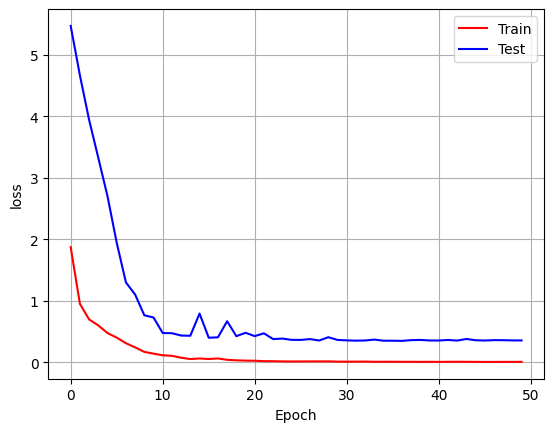

In [255]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_test_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

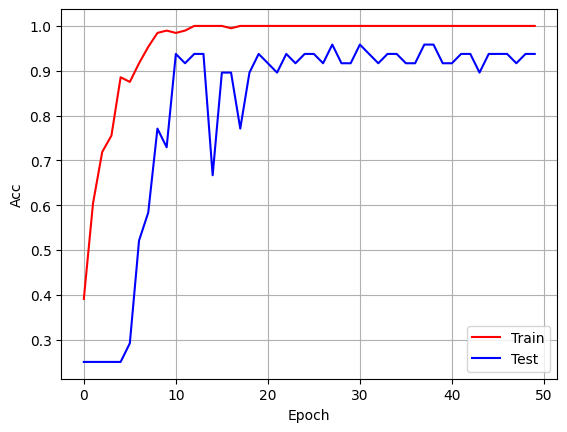

In [254]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_test_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()